
📊 Dataset Summary:
Split     Class                               Image Count
------------------------------------------------------------
train     aca                                        1468
train     n                                          1478
train     scc                                        1469
valid     aca                                        1000
valid     n                                          1000
valid     scc                                        1000
test      aca                                        1000
test      n                                          1000
test      scc                                        1000


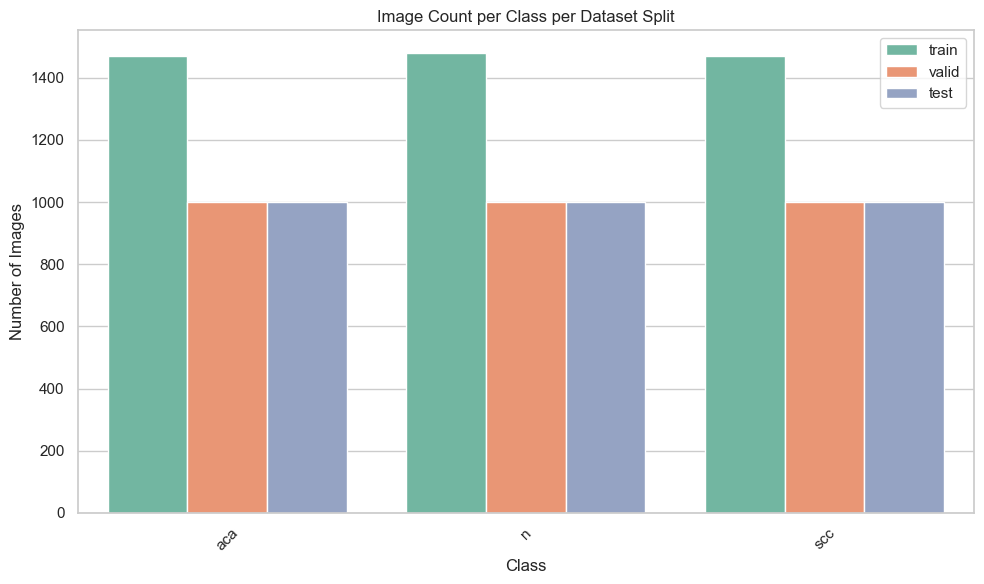


🖼 Showing example images (one per class from training set):


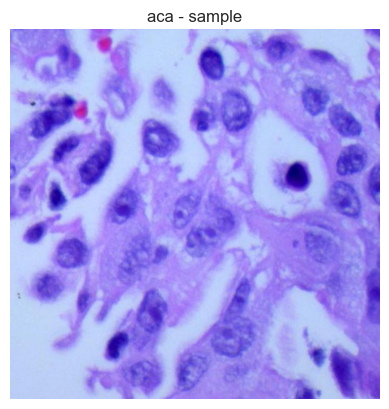

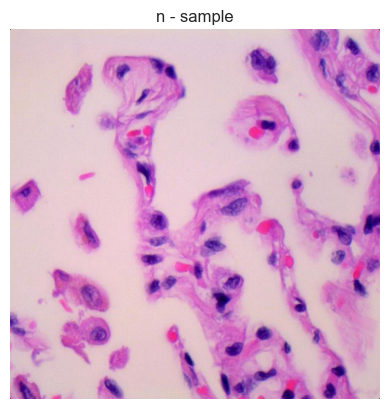

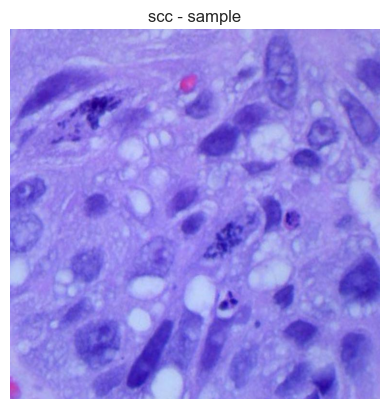

In [12]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import random
import cv2

# Dataset root path
base_path = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets'

# Splits to visualize
splits = ['train', 'valid', 'test']

# Dictionary to hold counts
data_counts = defaultdict(lambda: defaultdict(int))

# Count images
for split in splits:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        print(f"Missing folder: {split_path}")
        continue

    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

    for cls in classes:
        class_path = os.path.join(split_path, cls)
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        data_counts[split][cls] = len(images)

# Print counts in table form
print("\n📊 Dataset Summary:")
print(f"{'Split':<10}{'Class':<35}{'Image Count':>12}")
print("-" * 60)
for split in splits:
    for cls, count in data_counts[split].items():
        print(f"{split:<10}{cls:<35}{count:>12}")

# Plotting with seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for barplot
plot_data = []
for split in splits:
    for cls, count in data_counts[split].items():
        plot_data.append((split, cls, count))

# Unpack for plotting
split_names, class_names, counts = zip(*plot_data)
sns.barplot(x=class_names, y=counts, hue=split_names, palette="Set2", ax=ax)

ax.set_title("Image Count per Class per Dataset Split")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# OPTIONAL: Display a few sample images
show_samples = True
if show_samples:
    print("\n🖼 Showing example images (one per class from training set):")
    sample_split = 'train'
    for cls in data_counts[sample_split].keys():
        cls_path = os.path.join(base_path, sample_split, cls)
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            img_path = os.path.join(cls_path, random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{cls} - sample")
            plt.axis('off')
            plt.show()


In [ ]:
#Augmentation Code (Run only if Images are not augmented)

# import os
# import cv2
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define paths to the updated 750-image folders
# categories_paths = [
#     r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train\aca_train',
#     r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train\n_train',
#     r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train\scc_train'
# ]

# # Image augmentation configuration
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Process each category
# for category_path in categories_paths:
#     category_name = os.path.basename(category_path)
#     print(f"\nAugmenting images in: {category_name}")

#     # List only original images (excluding previously augmented ones)
#     images = [img for img in os.listdir(category_path)
#               if img.lower().endswith(('.jpg', '.jpeg', '.png')) and not img.startswith('aug_')]

#     for image_name in images:
#         image_path = os.path.join(category_path, image_name)
#         img = cv2.imread(image_path)

#         if img is None:
#             print(f"Failed to load image: {image_name}")
#             continue

#         img = cv2.resize(img, (200, 200))  # Resize to a consistent shape
#         img = np.expand_dims(img, axis=0)  # Add batch dimension

#         # Generate 1 augmented image
#         for batch in datagen.flow(img, batch_size=1, save_to_dir=category_path,
#                                   save_prefix='aug', save_format='jpeg'):
#             break  # Only generate one augmented image

#     print(f"Finished augmenting {len(images)} images in: {category_name}")

# print("\nAugmentation completed for all categories. Each folder should now contain 1500 images.")


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Paths
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image settings
image_size = (224, 224)
batch_size = 32
num_classes = 3

# Data generators (rescale only)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ✅ Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Computed class weights: {class_weights_dict}")

# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base initially

resnet_model_final = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with warm-up learning rate
resnet_model_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall()]
)

resnet_model_final.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ✅ Train with class weights
history = resnet_model_final.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Save model
resnet_model_final.save('resnet_final_model_warmup.keras')

# Evaluate
test_loss, test_acc, test_recall = resnet_model_final.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}, Test recall: {test_recall:.4f}')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Computed class weights: {0: np.float64(1.0024977293369663), 1: np.float64(0.9957149300857014), 2: np.float64(1.0018152938506921)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.3762 - loss: 1.2279 - recall: 0.1691 - val_accuracy: 0.4590 - val_loss: 1.0524 - val_recall: 0.1700
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.4348 - loss: 1.0503 - recall: 0.1015 - val_accuracy: 0.5047 - val_loss: 1.0049 - val_recall: 0.0680
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.4717 - loss: 1.0115 - recall: 0.1373 - val_accuracy: 0.5107 - val_loss: 0.9893 - val_recall: 0.1613
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5043 - loss: 0.9953 - recall: 0.1401 - val_accuracy: 0.5267 - val_loss: 0.9983 - val_recall: 0.0870
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.4872 - loss: 0.9976 - recall: 0.1443 - val_accuracy: 0.5353 - val_loss: 0.9596 - val_recall: 0.1893
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.4965 - loss: 1.0029 - recall: 0.1596 - val_accuracy: 0.5310 - val_loss: 0.9498 - val_recall: 0.232

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Paths
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image and batch settings
image_size = (224, 224)
batch_size = 32
num_classes = 3

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Computed class weights: {class_weights_dict}")

# Load the saved model
resnet_model = tf.keras.models.load_model('resnet_final_model_warmup.keras')

# Unfreeze top layers of ResNet50 for fine-tuning
resnet_model.layers[0].trainable = True

# Freeze first 100 layers (tune only the rest)
for layer in resnet_model.layers[0].layers[:100]:
    layer.trainable = False

# Compile with lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall()]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fine-tune the model
history_finetune = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# Save the fine-tuned model
resnet_model.save('resnet_finetuned_model.keras')

# Evaluate
test_loss, test_acc, test_recall = resnet_model.evaluate(test_generator)
print(f"Fine-tuned Test accuracy: {test_acc:.4f}, Test recall: {test_recall:.4f}")


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Computed class weights: {0: np.float64(1.0024977293369663), 1: np.float64(0.9957149300857014), 2: np.float64(1.0018152938506921)}


C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 698s 5s/step - accuracy: 0.5062 - loss: 1.5500 - recall_1: 0.4084 - val_accuracy: 0.3333 - val_loss: 3.8676 - val_recall_1: 0.3333
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.7067 - loss: 0.6454 - recall_1: 0.6578 - val_accuracy: 0.4237 - val_loss: 2.2443 - val_recall_1: 0.4237
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 675s 5s/step - accuracy: 0.7537 - loss: 0.5469 - recall_1: 0.7161 - val_accuracy: 0.5600 - val_loss: 0.7494 - val_recall_1: 0.5573
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - accuracy: 0.8161 - loss: 0.4513 - recall_1: 0.7903 - val_accuracy: 0.7690 - val_loss: 0.5018 - val_recall_1: 0.7590
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 657s 5s/step - accuracy: 0.8227 - loss: 0.4121 - recall_1: 0.8132 - val_accuracy: 0.8083 - val_loss: 0.4486 - val_recall_1: 0.8040
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 666s 5s/step - accuracy: 0.8426 - loss: 0.3759 - recall_1: 0.8333 - val_accuracy: 0.7263 - val_loss: 0.69

In [3]:
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

# Define paths
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image and batch size
image_size = (200, 200)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Define model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
base_model.trainable = False  # Freeze base

vgg_model_final = models.Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile with lower learning rate
vgg_model_final.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_loss', save_best_only=True)

# Train model
history = vgg_model_final.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    class_weight=class_weights
)

# Evaluate model
test_loss, test_acc = vgg_model_final.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Save final model
vgg_model_final.save('final_model_vgg16.keras')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Computed class weights: {0: np.float64(1.0024977293369663), 1: np.float64(0.9957149300857014), 2: np.float64(1.0018152938506921)}


C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1009s 7s/step - accuracy: 0.7725 - loss: 0.8566 - val_accuracy: 0.8713 - val_loss: 0.3182
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1216s 9s/step - accuracy: 0.9066 - loss: 0.2291 - val_accuracy: 0.9403 - val_loss: 0.1501
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1358s 10s/step - accuracy: 0.9340 - loss: 0.1684 - val_accuracy: 0.9383 - val_loss: 0.1662
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1697s 12s/step - accuracy: 0.9291 - loss: 0.1775 - val_accuracy: 0.9303 - val_loss: 0.1750
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 2035s 15s/step - accuracy: 0.9289 - loss: 0.1658 - val_accuracy: 0.9613 - val_loss: 0.0955
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1046s 8s/step - accuracy: 0.9414 - loss: 0.1495 - val_accuracy: 0.9570 - val_loss: 0.1113
Epoch 7/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1033s 8s/step - accuracy: 0.9449 - loss: 0.1354 - val_accuracy: 0.9610 - val_loss: 0.1021
Epoch 8/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 1032s 8s/step - accuracy: 0.9471 - loss: 0.1384

In [5]:
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

# Paths
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Parameters
image_size = (200, 200)
batch_size = 32
num_classes = 3

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Load Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
base_model.trainable = False  # Freeze base

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_mobilenetv2.keras', monitor='val_loss', save_best_only=True)

# Train Model
history = mobilenet_model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    class_weight=class_weights
)

# Evaluate on Test Set
test_loss, test_acc, test_recall = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 Test accuracy: {test_acc:.4f}, Test recall: {test_recall:.4f}")

# Save Final Model
mobilenet_model.save('final_model_mobilenetv2.keras')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Computed class weights: {0: np.float64(1.0024977293369663), 1: np.float64(0.9957149300857014), 2: np.float64(1.0018152938506921)}


C:\Users\user\AppData\Local\Temp\ipykernel_4588\1465994849.py:70: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.8087 - loss: 0.4823 - recall: 0.8023 - val_accuracy: 0.9400 - val_loss: 0.1592 - val_recall: 0.9400
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 102s 742ms/step - accuracy: 0.9227 - loss: 0.1857 - recall: 0.9227 - val_accuracy: 0.9370 - val_loss: 0.1595 - val_recall: 0.9370
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 104s 757ms/step - accuracy: 0.9475 - loss: 0.1452 - recall: 0.9475 - val_accuracy: 0.9427 - val_loss: 0.1635 - val_recall: 0.9427
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 770ms/step - accuracy: 0.9425 - loss: 0.1435 - recall: 0.9425 - val_accuracy: 0.9443 - val_loss: 0.1557 - val_recall: 0.9443
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 107s 780ms/step - accuracy: 0.9358 - loss: 0.1586 - recall: 0.9358 - val_accuracy: 0.9160 - val_loss: 0.2389 - val_recall: 0.9160
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 109s 789ms/step - accuracy: 0.9328 - loss: 0.1572 - recall: 0.9328 - val_accuracy: 0.9490 - val_loss: 0.1372 - va

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Paths
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image settings
image_size = (299, 299)  # Xception uses 299x299
batch_size = 32
num_classes = 3

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Compute class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base initially

# Add custom classification layers
xception_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
xception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Recall()]
)

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = xception_model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# Evaluate
test_loss, test_acc, test_recall = xception_model.evaluate(test_generator)
print(f"Xception Test Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}")

# Save
xception_model.save('xception_lung_model.keras')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 3076s 22s/step - accuracy: 0.8296 - loss: 0.3708 - recall: 0.8028 - val_accuracy: 0.9470 - val_loss: 0.1284 - val_recall: 0.9470
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 2921s 21s/step - accuracy: 0.9382 - loss: 0.1478 - recall: 0.9372 - val_accuracy: 0.9597 - val_loss: 0.1040 - val_recall: 0.9597
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 2363s 17s/step - accuracy: 0.9511 - loss: 0.1291 - recall: 0.9511 - val_accuracy: 0.9520 - val_loss: 0.1186 - val_recall: 0.9520
Epoch 4/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 861s 6s/step - accuracy: 0.9528 - loss: 0.1133 - recall: 0.9528 - val_accuracy: 0.9647 - val_loss: 0.0900 - val_recall: 0.9647
Epoch 5/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 854s 6s/step - accuracy: 0.9570 - loss: 0.0963 - recall: 0.9565 - val_accuracy: 0.9643 - val_loss: 0.0875 - val_recall: 0.9643
Epoch 6/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 848s 6s/step - accuracy: 0.9670 - loss: 0.0839 - recall: 0.9670 - val_accuracy: 0.9643 - val_loss: 0.0893 - val_recall:

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
Y_pred = resnet_model_final.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix (optional for insight)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


94/94 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step
Classification Report:
               precision    recall  f1-score   support

         aca       0.58      0.31      0.41      1000
           n       0.74      0.87      0.80      1000
         scc       0.64      0.82      0.72      1000

    accuracy                           0.67      3000
   macro avg       0.65      0.67      0.64      3000
weighted avg       0.65      0.67      0.64      3000

Confusion Matrix:
 [[314 269 417]
 [ 80 871  49]
 [146  35 819]]


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
Y_pred = resnet_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix (optional for insight)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


94/94 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step
Classification Report:
               precision    recall  f1-score   support

         aca       0.78      0.79      0.78      1000
           n       0.90      0.96      0.93      1000
         scc       0.88      0.81      0.84      1000

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000

Confusion Matrix:
 [[789 102 109]
 [ 38 962   0]
 [187   4 809]]


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
Y_pred = vgg_model_final.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix (optional for insight)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

94/94 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step
Classification Report:
               precision    recall  f1-score   support

         aca       0.95      0.94      0.95      1000
           n       1.00      0.99      1.00      1000
         scc       0.94      0.96      0.95      1000

    accuracy                           0.96      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.97      0.96      0.97      3000

Confusion Matrix:
 [[941   3  56]
 [  5 995   0]
 [ 41   0 959]]


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
Y_pred = mobilenet_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix (optional for insight)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step
Classification Report:
               precision    recall  f1-score   support

         aca       0.95      0.93      0.94      1000
           n       1.00      1.00      1.00      1000
         scc       0.93      0.96      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Confusion Matrix:
 [[925   5  70]
 [  1 999   0]
 [ 43   0 957]]


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
Y_pred = xception_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix (optional for insight)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

94/94 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step
Classification Report:
               precision    recall  f1-score   support

         aca       0.96      0.96      0.96      1000
           n       1.00      1.00      1.00      1000
         scc       0.96      0.97      0.96      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

Confusion Matrix:
 [[956   1  43]
 [  2 998   0]
 [ 33   0 967]]


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools


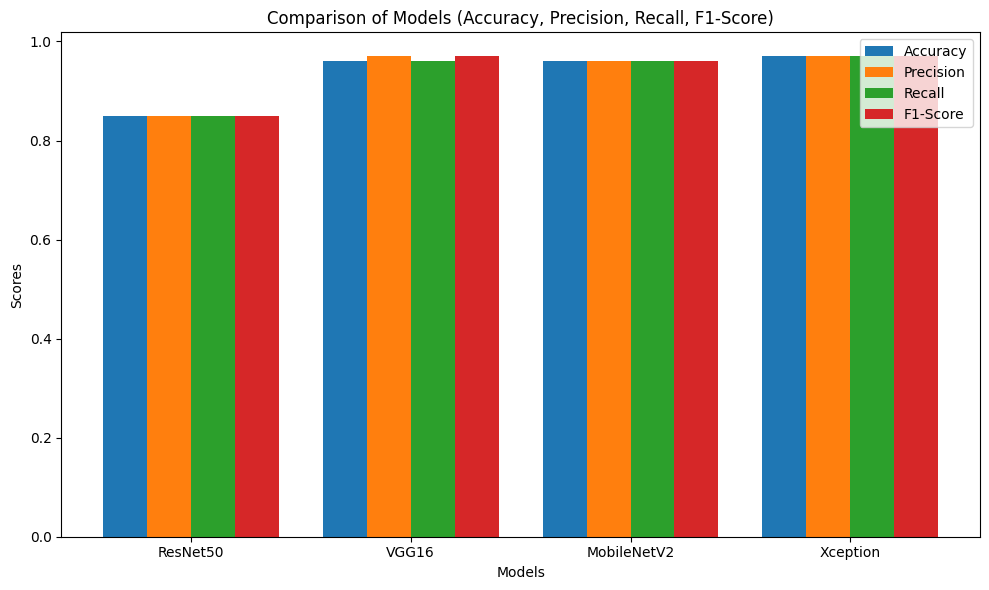

In [5]:
# Metrics data for the four models
models = ['ResNet50', 'VGG16', 'MobileNetV2', 'Xception']
accuracy = [0.85, 0.96, 0.96, 0.97]
precision = [0.85, 0.97, 0.96, 0.97]
recall = [0.85, 0.96, 0.96, 0.97]
f1_score = [0.85, 0.97, 0.96, 0.97]

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Set the width of the bars
bar_width = 0.2
index = np.arange(len(models))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, metrics_df['Accuracy'], bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, metrics_df['Precision'], bar_width, label='Precision')
bar3 = ax.bar(index + 2 * bar_width, metrics_df['Recall'], bar_width, label='Recall')
bar4 = ax.bar(index + 3 * bar_width, metrics_df['F1-Score'], bar_width, label='F1-Score')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models (Accuracy, Precision, Recall, F1-Score)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


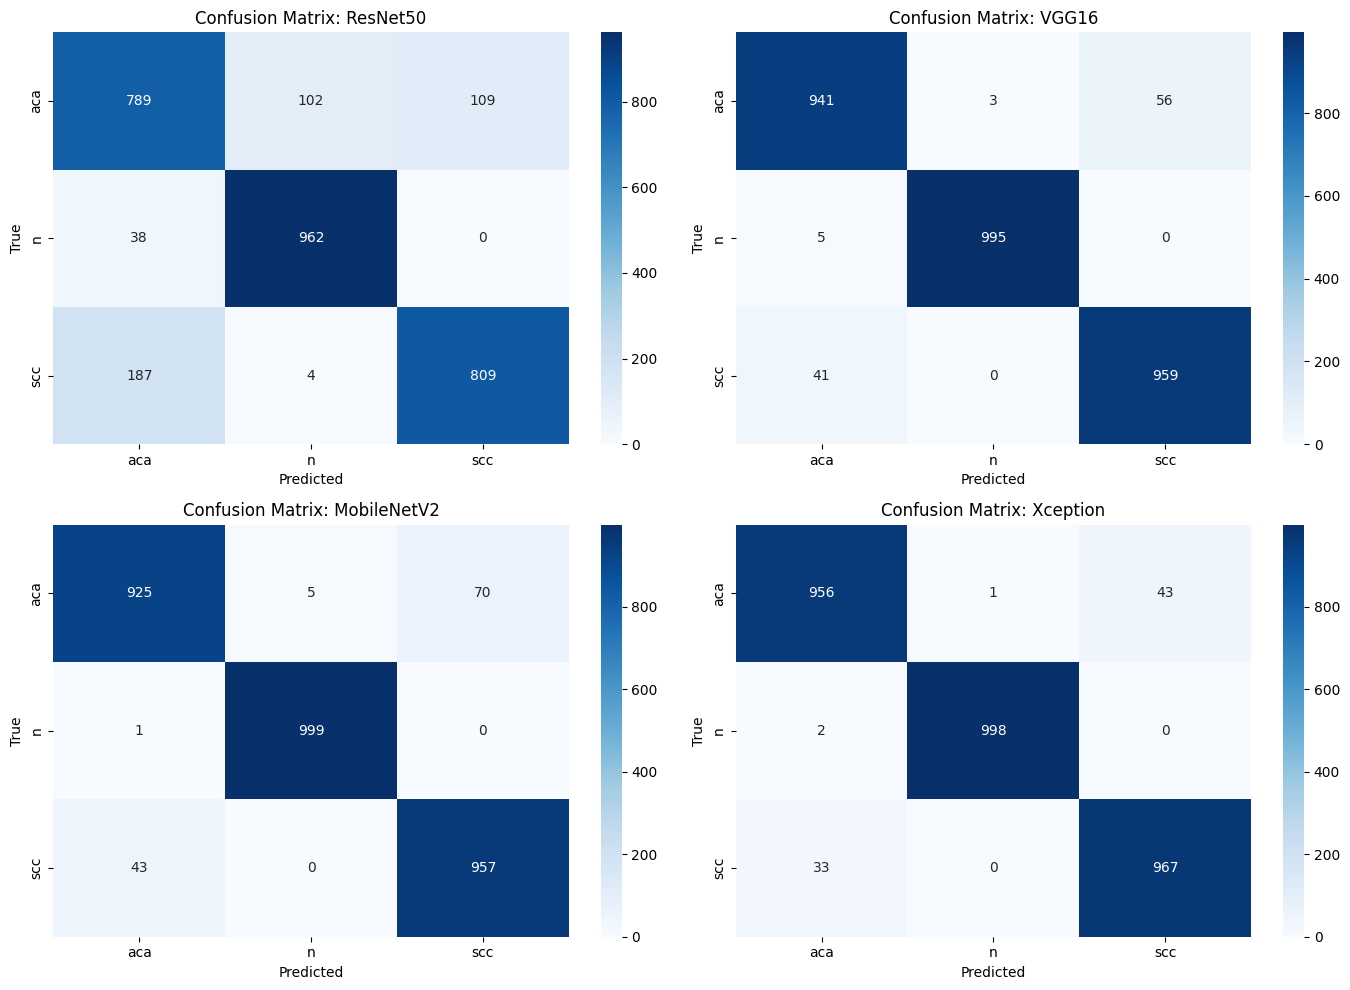

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrices
conf_matrices = {
    'ResNet50': [[789, 102, 109], 
                 [38, 962, 0], 
                 [187, 4, 809]],
    'VGG16': [[941, 3, 56], 
              [5, 995, 0], 
              [41, 0, 959]],
    'MobileNetV2': [[925, 5, 70], 
                    [1, 999, 0], 
                    [43, 0, 957]],
    'Xception': [[956, 1, 43], 
                 [2, 998, 0], 
                 [33, 0, 967]]
}

# Function to plot on a specific Axes
def plot_confusion_matrix(cm, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['aca', 'n', 'scc'],
                yticklabels=['aca', 'n', 'scc'],
                ax=ax)  # <- Correct: plot on the passed Axes
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each model’s confusion matrix on its own Axes
for i, (model, cm) in enumerate(conf_matrices.items()):
    plot_confusion_matrix(cm, model, axes[i])

plt.tight_layout()
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import Sequence

# Image size and batch
img_size = (224, 224)
batch_size = 32

# Data directories
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir  = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True)
valid_gen = datagen.flow_from_directory(valid_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(test_dir,  target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Define two separate inputs
input_x = Input(shape=(224, 224, 3), name='x_input')
input_v = Input(shape=(224, 224, 3), name='v_input')

# Load base models
base_x = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_v = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze base models
base_x.trainable = False
base_v.trainable = False

# Extract features
x_features = base_x(input_x)
v_features = base_v(input_v)

# Pooling
x_pool = GlobalAveragePooling2D()(x_features)
v_pool = GlobalAveragePooling2D()(v_features)

# Merge
merged = Concatenate()([x_pool, v_pool])
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(3, activation='softmax')(merged)

# Final model
model = Model(inputs=[input_x, input_v], outputs=output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
model.summary()

# Custom data generator for dual input
class DualInputGenerator(Sequence):
    def __init__(self, base_generator):
        self.base_generator = base_generator

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        images, labels = self.base_generator[idx]
        return {'x_input': images, 'v_input': images}, labels

    def on_epoch_end(self):
        self.base_generator.on_epoch_end()

train_dual = DualInputGenerator(train_gen)
valid_dual = DualInputGenerator(valid_gen)
test_dual  = DualInputGenerator(test_gen)

# Save the best model during training
checkpoint = ModelCheckpoint(
    'fusion_xception_vgg16_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model
history = model.fit(
    train_dual,
    validation_data=valid_dual,
    epochs=10,
    callbacks=[checkpoint]
)

# Load best weights (optional)
model.load_weights('fusion_xception_vgg16_best_model.h5')

# Evaluate
test_loss, test_acc = model.evaluate(test_dual)
print(f'Test Accuracy: {test_acc:.4f}')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)          │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ v_input (InputLayer)          │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xception (Functional)         │ (None, 7, 7, 2048)        │      20,861,480 │ x_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 7, 7, 512)         │      14,714,688 │ v_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_4    │ (None, 2048)              │               0 │ xception[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_5    │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 2560)              │               0 │ global_average_pooling2d_… │
│                               │                           │                 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 512)               │       1,311,232 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 512)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 3)                 │           1,539 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 36,888,939 (140.72 MB)

 Trainable params: 1,312,771 (5.01 MB)

 Non-trainable params: 35,576,168 (135.71 MB)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7557 - loss: 0.5813
Epoch 1: val_accuracy improved from -inf to 0.93633, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 1562s 11s/step - accuracy: 0.7564 - loss: 0.5800 - val_accuracy: 0.9363 - val_loss: 0.1918
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9215 - loss: 0.2186
Epoch 2: val_accuracy improved from 0.93633 to 0.94500, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 1659s 12s/step - accuracy: 0.9215 - loss: 0.2185 - val_accuracy: 0.9450 - val_loss: 0.1493
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9360 - loss: 0.1702
Epoch 3: val_accuracy improved from 0.94500 to 0.95300, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 1697s 12s/step - accuracy: 0.9360 - loss: 0.1702 - val_accuracy: 0.9530 - val_loss: 0.1271
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9505 - loss: 0.1359 
Epoch 4: val_accuracy improved from 0.95300 to 0.96067, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 3004s 22s/step - accuracy: 0.9504 - loss: 0.1360 - val_accuracy: 0.9607 - val_loss: 0.1110
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9586 - loss: 0.1207 
Epoch 5: val_accuracy did not improve from 0.96067
138/138 ━━━━━━━━━━━━━━━━━━━━ 3794s 28s/step - accuracy: 0.9585 - loss: 0.1207 - val_accuracy: 0.9583 - val_loss: 0.1153
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9639 - loss: 0.1095
Epoch 6: val_accuracy improved from 0.96067 to 0.96867, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 1655s 12s/step - accuracy: 0.9638 - loss: 0.1095 - val_accuracy: 0.9687 - val_loss: 0.0965
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9628 - loss: 0.1060
Epoch 7: val_accuracy improved from 0.96867 to 0.96933, saving model to fusion_xception_vgg16_best_model.h5


138/138 ━━━━━━━━━━━━━━━━━━━━ 1583s 12s/step - accuracy: 0.9628 - loss: 0.1059 - val_accuracy: 0.9693 - val_loss: 0.0908
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9596 - loss: 0.1043
Epoch 8: val_accuracy did not improve from 0.96933
138/138 ━━━━━━━━━━━━━━━━━━━━ 1585s 12s/step - accuracy: 0.9596 - loss: 0.1043 - val_accuracy: 0.9680 - val_loss: 0.0876
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9663 - loss: 0.0938
Epoch 9: val_accuracy did not improve from 0.96933
138/138 ━━━━━━━━━━━━━━━━━━━━ 1605s 12s/step - accuracy: 0.9663 - loss: 0.0938 - val_accuracy: 0.9670 - val_loss: 0.0919
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9693 - loss: 0.0883
Epoch 10: val_accuracy did not improve from 0.96933
138/138 ━━━━━━━━━━━━━━━━━━━━ 1614s 12s/step - accuracy: 0.9693 - loss: 0.0882 - val_accuracy: 0.9660 - val_loss: 0.0850
94/94 ━━━━━━━━━━━━━━━━━━━━ 667s 7s/step - accuracy: 0.9652 - loss: 0.1059
Test Accuracy: 0.9660


94/94 ━━━━━━━━━━━━━━━━━━━━ 659s 7s/step
Classification Report:
              precision    recall  f1-score   support

         aca       0.94      0.95      0.95      1000
           n       1.00      1.00      1.00      1000
         scc       0.96      0.95      0.95      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



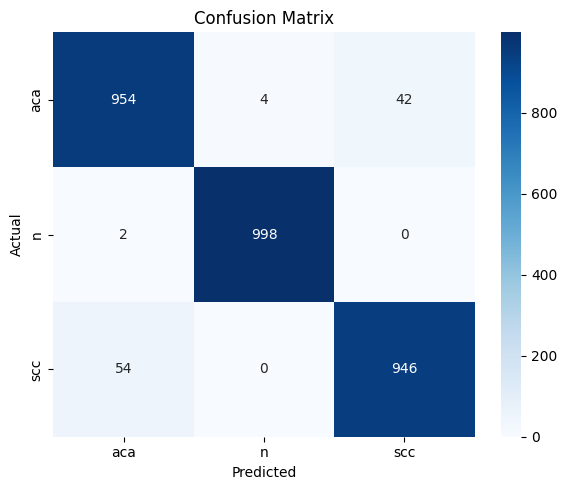

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the test generator
y_pred_probs = model.predict(test_dual)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the original test generator
y_true = test_gen.classes  # correct way to get ground truth labels

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Dropout,
                                     Concatenate, Conv2D, Multiply, Add, Reshape,
                                     Activation, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

# Image size and batch
img_size = (224, 224)
batch_size = 32

# Data directories
train_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\train'
valid_dir = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\valid'
test_dir  = r'D:\Major Project\archive\lung_colon_image_set\lung_image_sets\test'

# Image data generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True)
valid_gen = datagen.flow_from_directory(valid_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(test_dir,  target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# --------------------- CBAM Layer (Wrapped for Keras compatibility) ---------------------
class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]

        self.shared_dense_one = Dense(channel // self.ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
        self.shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)
        self.conv_spatial = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

        super(CBAM, self).build(input_shape)

    def call(self, inputs):
        # Channel Attention
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, avg_pool.shape[1]))(avg_pool)
        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))

        max_pool = Lambda(lambda x: K.max(x, axis=[1, 2], keepdims=True))(inputs)
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))

        channel_attention = Add()([avg_out, max_out])
        channel_attention = Activation('sigmoid')(channel_attention)
        channel_refined = Multiply()([inputs, channel_attention])

        # Spatial Attention
        avg_pool_spatial = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
        max_pool_spatial = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
        concat = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
        spatial_attention = self.conv_spatial(concat)
        refined_feature = Multiply()([channel_refined, spatial_attention])
        return refined_feature
# ----------------------------------------------------------------------------------------

# Define two separate inputs
input_x = Input(shape=(224, 224, 3), name='x_input')
input_v = Input(shape=(224, 224, 3), name='v_input')

# Load base models
base_x = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_v = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze base models
base_x.trainable = False
base_v.trainable = False

# Extract features
x_features = base_x(input_x)
v_features = base_v(input_v)

# Apply CBAM attention to feature maps
x_features = CBAM()(x_features)  # ✅ CBAM added here
v_features = CBAM()(v_features)  # ✅ CBAM added here

# Pooling
x_pool = GlobalAveragePooling2D()(x_features)
v_pool = GlobalAveragePooling2D()(v_features)

# Merge
merged = Concatenate()([x_pool, v_pool])
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(3, activation='softmax')(merged)

# Final model
model = Model(inputs=[input_x, input_v], outputs=output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary
model.summary()

# Custom data generator for dual input
class DualInputGenerator(Sequence):
    def __init__(self, base_generator):
        self.base_generator = base_generator

    def __len__(self):
        return len(self.base_generator)

    def __getitem__(self, idx):
        images, labels = self.base_generator[idx]
        return {'x_input': images, 'v_input': images}, labels

    def on_epoch_end(self):
        self.base_generator.on_epoch_end()

train_dual = DualInputGenerator(train_gen)
valid_dual = DualInputGenerator(valid_gen)
test_dual  = DualInputGenerator(test_gen)

# Save the best model during training
checkpoint = ModelCheckpoint(
    'fusion_xception_vgg16_cbam_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model
history = model.fit(
    train_dual,
    validation_data=valid_dual,
    epochs=10,
    callbacks=[checkpoint]
)

# Load best weights (optional)
model.load_weights('fusion_xception_vgg16_cbam_best_model.keras')

# Evaluate
test_loss, test_acc = model.evaluate(test_dual)
print(f'Test Accuracy: {test_acc:.4f}')


Found 4415 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)          │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ v_input (InputLayer)          │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ xception (Functional)         │ (None, 7, 7, 2048)        │      20,861,480 │ x_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 7, 7, 512)         │      14,714,688 │ v_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cbam (CBAM)                   │ (None, 7, 7, 2048)        │       1,050,978 │ xception[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cbam_1 (CBAM)                 │ (None, 7, 7, 512)         │          66,210 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_3    │ (None, 2048)              │               0 │ cbam[0][0]                 │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_4    │ (None, 512)               │               0 │ cbam_1[0][0]               │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 2560)              │               0 │ global_average_pooling2d_… │
│                               │                           │                 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 512)               │       1,311,232 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 3)                 │           1,539 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,006,127 (144.98 MB)

 Trainable params: 2,429,959 (9.27 MB)

 Non-trainable params: 35,576,168 (135.71 MB)

C:\Users\user\anaconda3\envs\Lungcancer\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7472 - loss: 0.7868
Epoch 1: val_accuracy improved from -inf to 0.92900, saving model to fusion_xception_vgg16_cbam_best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 1593s 12s/step - accuracy: 0.7479 - loss: 0.7851 - val_accuracy: 0.9290 - val_loss: 0.2180
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9256 - loss: 0.2191
Epoch 2: val_accuracy improved from 0.92900 to 0.94300, saving model to fusion_xception_vgg16_cbam_best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 1633s 12s/step - accuracy: 0.9256 - loss: 0.2190 - val_accuracy: 0.9430 - val_loss: 0.1449
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9549 - loss: 0.1358
Epoch 3: val_accuracy improved from 0.94300 to 0.95500, saving model to fusion_xception_vgg16_cbam_best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 1651s 12s/step - accuracy: 0.9548 - loss: 0.1358 - val_accuracy: 0.9550 - val_loss: 0.1130
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 

94/94 ━━━━━━━━━━━━━━━━━━━━ 675s 7s/step
Classification Report:
              precision    recall  f1-score   support

         aca       0.95      0.97      0.96      1000
           n       1.00      1.00      1.00      1000
         scc       0.97      0.95      0.96      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



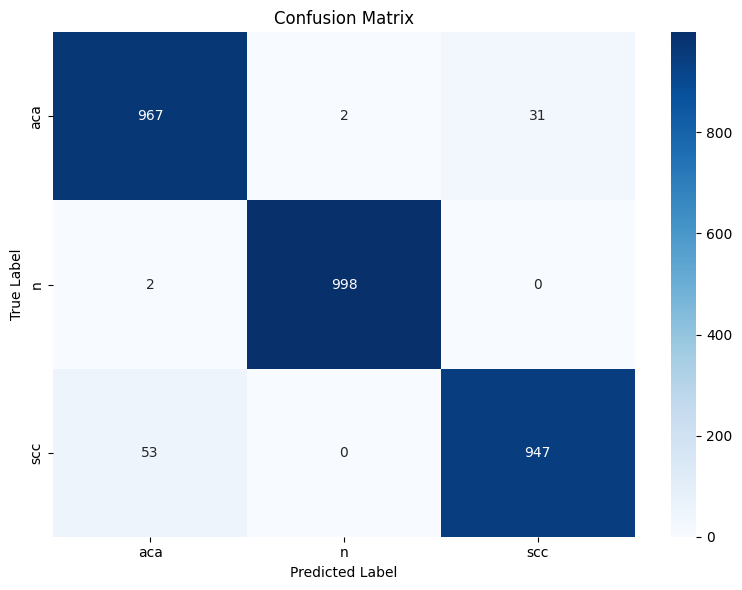

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Get predictions
pred_probs = model.predict(test_dual)
pred_labels = np.argmax(pred_probs, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


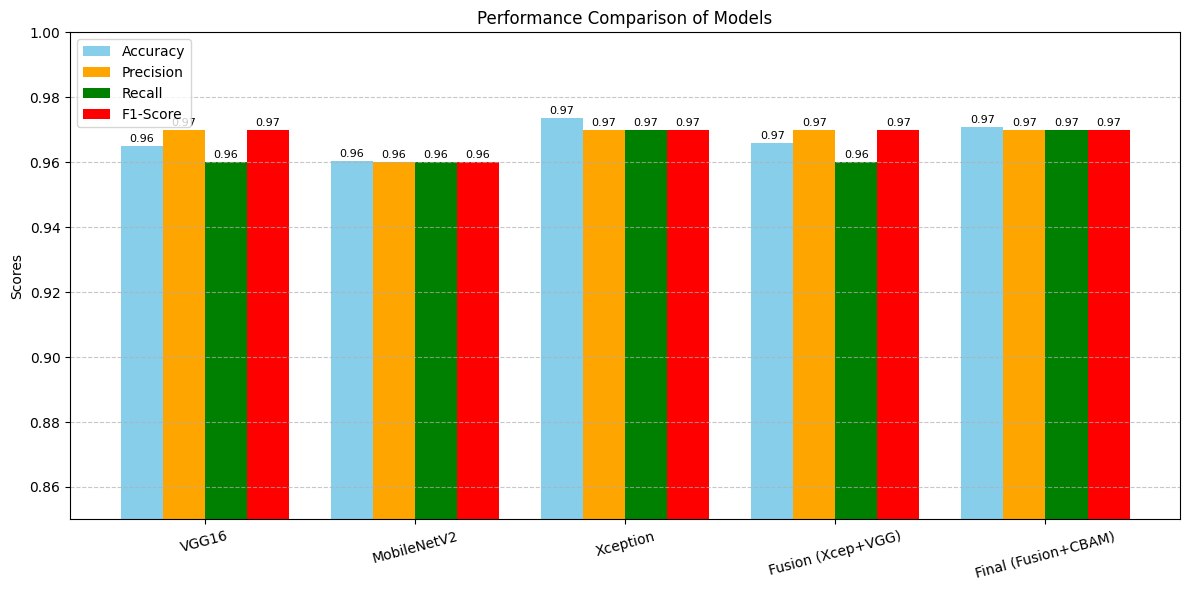

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['VGG16', 'MobileNetV2', 'Xception', 'Fusion (Xcep+VGG)', 'Final (Fusion+CBAM)']

# Actual performance metrics
accuracy  = [0.9650, 0.9603, 0.9737, 0.9660, 0.9707]
precision = [0.97, 0.96, 0.97, 0.97, 0.97]
recall    = [0.96, 0.96, 0.97, 0.96, 0.97]
f1_score  = [0.97, 0.96, 0.97, 0.97, 0.97]

# X-axis locations
x = np.arange(len(models))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - 1.5*width, accuracy,  width, label='Accuracy', color='skyblue')
bar2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='orange')
bar3 = ax.bar(x + 0.5*width, recall,    width, label='Recall', color='green')
bar4 = ax.bar(x + 1.5*width, f1_score,  width, label='F1-Score', color='red')

# Labeling
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0.85, 1.00)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate scores on bars
for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


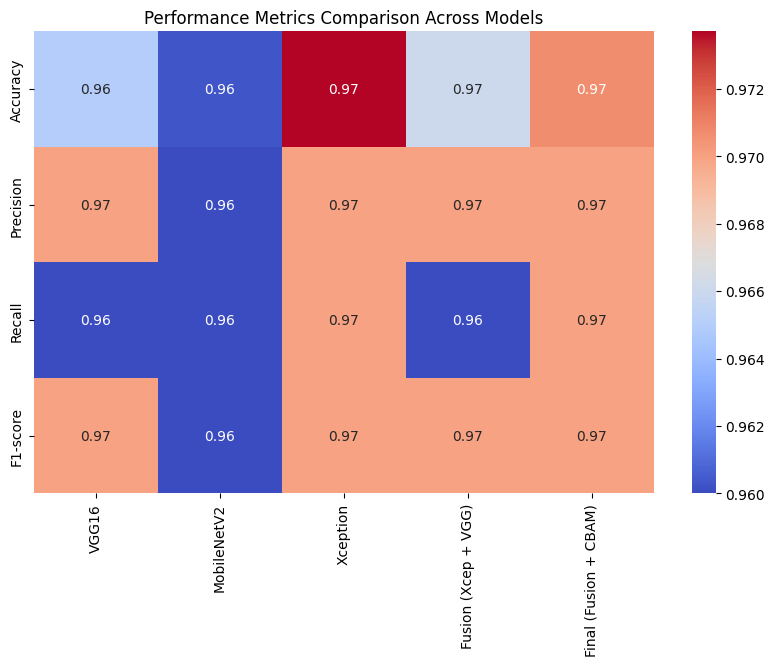

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance metrics (accuracy, precision, recall, f1-score for each model)
performance = {
    'VGG16': [0.9650, 0.97, 0.96, 0.97],
    'MobileNetV2': [0.9603, 0.96, 0.96, 0.96],
    'Xception': [0.9737, 0.97, 0.97, 0.97],
    'Fusion (Xcep + VGG)': [0.9660, 0.97, 0.96, 0.97],
    'Final (Fusion + CBAM)': [0.9707, 0.97, 0.97, 0.97]
}

# Convert to DataFrame for easier plotting
import pandas as pd
performance_df = pd.DataFrame(performance, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title('Performance Metrics Comparison Across Models')
plt.show()
